Problem 3 (30 pts)  
Consider the prostate cancer data. Implement the following two methods to fit the data in the training set. 

• Method I, ridge regression  
• Method II, generalized ridge regression with regularization using reproducing Gaussian kernel: K(x, y) = e −ν∥x−y∥ 2 2 , where ν = 1. 

The dataset has eight features: (lcavol, lweight, age, lbph, svi, lcp, gleason, pgg45). The last column (lpsa) is the response.  

Note that for method I, you need to center and scale the features (see book page 64), but for method II, you do not need to.   



(1) Report the mean squared error (formula MSE: $1/n \sum\limits_{i=1}^{n} (y_i - \hat{y_i})^2$)   
for the testing dataset at λ = {0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100} for both methods. 

## DATA PREPARATION

In [225]:
# Importing the needed modules

import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Loading the data from a GitHub link in order to make the code universal

path = 'https://raw.githubusercontent.com/ferriitoo/csv/main/'
df_train = pd.read_csv(path + 'prostate.training.txt', sep='\t')
df_test = pd.read_csv(path + 'prostate.testing.txt', sep='\t')

# Extracting the features and the response variables
# (splitting the data into training and testing sets has been already done by the instructor)

X_train = df_train[['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']].values
X_test = df_test[['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']].values
y_train = df_train['lpsa'].values
y_test = df_test['lpsa'].values

def data_transform(x):
    # centering and scaling the data
    return (x - x.mean(axis=0)) / x.std(axis=0)

# centering and scaling the data
X_train_scaled = data_transform(X_train)
X_test_scaled = data_transform(X_test)
y_train_scaled = data_transform(y_train)
y_test_scaled = data_transform(y_test)

# center and scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


# Define the lambda values to test
lambdas = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

## MODEL BUILDING

In [226]:
# METHOD 2
class GeneralizedRidgeRegression:
    
    def __init__(self, kernel='gaussian', nu=1):
        self.kernel = kernel
        self.nu = nu
    
    def fit(self, X, y, lambd):
        # Compute the kernel matrix
        if self.kernel == 'gaussian':
            K = self.gaussian_kernel(X, X)
        else:
            raise ValueError('Kernel not supported')
        
        # Compute the regularization term
        n = X.shape[0]
        reg = lambd * np.identity(n)
        
        # Compute the regression coefficients
        beta = np.linalg.inv(K + reg) @ y
        #print(beta.shape)

        return beta
    
    def predict(self, X_train, X_test, y_train, lambd):
        # Compute the kernel matrices
        if self.kernel == 'gaussian':
            K_train = self.gaussian_kernel(X_train, X_train)
            K_test = self.gaussian_kernel(X_test, X_train)
        else:
            raise ValueError('Kernel not supported')
        
        # Compute the regression coefficients
        beta = self.fit(X_train, y_train, lambd)
        
        # Compute the predicted values
        y_pred = K_test @ beta
        
        return y_pred
    
    def gaussian_kernel(self, X1, X2):
        n1 = X1.shape[0]
        n2 = X2.shape[0]
        K = np.zeros((n1, n2))
        for i in range(n1):
            for j in range(n2):
                diff = X1[i] - X2[j]
                K[i, j] = np.exp(-self.nu * np.dot(diff, diff))
        return K

# METHOD 1

class RidgeRegression:
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    
    def fit(self, X, y):
        n_features = X.shape[1]
        X = np.hstack((X, np.ones((X.shape[0], 1))))
        self.beta = np.linalg.inv(X.T @ X + self.alpha * np.eye(n_features+1)) @ X.T @ y
    
    def predict(self, X):
        X = np.hstack((X, np.ones((X.shape[0], 1))))
        return X @ self.beta

## RUNNING EXPERIMENTS

In [227]:
# Performing ridge regression and generalized ridge regression with reproducing Gaussian kernel

# Initialize the models
ridge = RidgeRegression()
kernel_ridge = GeneralizedRidgeRegression(kernel='gaussian', nu=1)

# Fit and predict using ridge regression
ridge_mse = []
kernel_mse = []

for l in lambdas:
    # Ridge Regression
    ridge.alpha = l
    ridge.fit(X_train_scaled, y_train_scaled)
    y_pred = ridge.predict(X_test_scaled)
    mse = mean_squared_error(y_test_scaled, y_pred)
    mse = round(mse, 2)
    ridge_mse.append(mse)

    # Generalized Ridge Regression with Gaussian kernel
    kernel_ridge.fit(X_train, y_train, l)
    y_pred = kernel_ridge.predict(X_train, X_test, y_train, l)
    mse = mean_squared_error(y_test, y_pred)
    mse = round(mse, 2)
    kernel_mse.append(mse)

    

## ANALYSIS OF RESULTS

Lambda	Ridge MSE	Kernel Ridge MSE
0	0.8200		20.3300
10	0.7400		20.7300
20	0.7100		20.7500
30	0.6900		20.7500
40	0.6900		20.7600
50	0.6900		20.7600
60	0.6900		20.7600
70	0.7000		20.7600
80	0.7000		20.7600
90	0.7100		20.7600
100	0.7100		20.7700


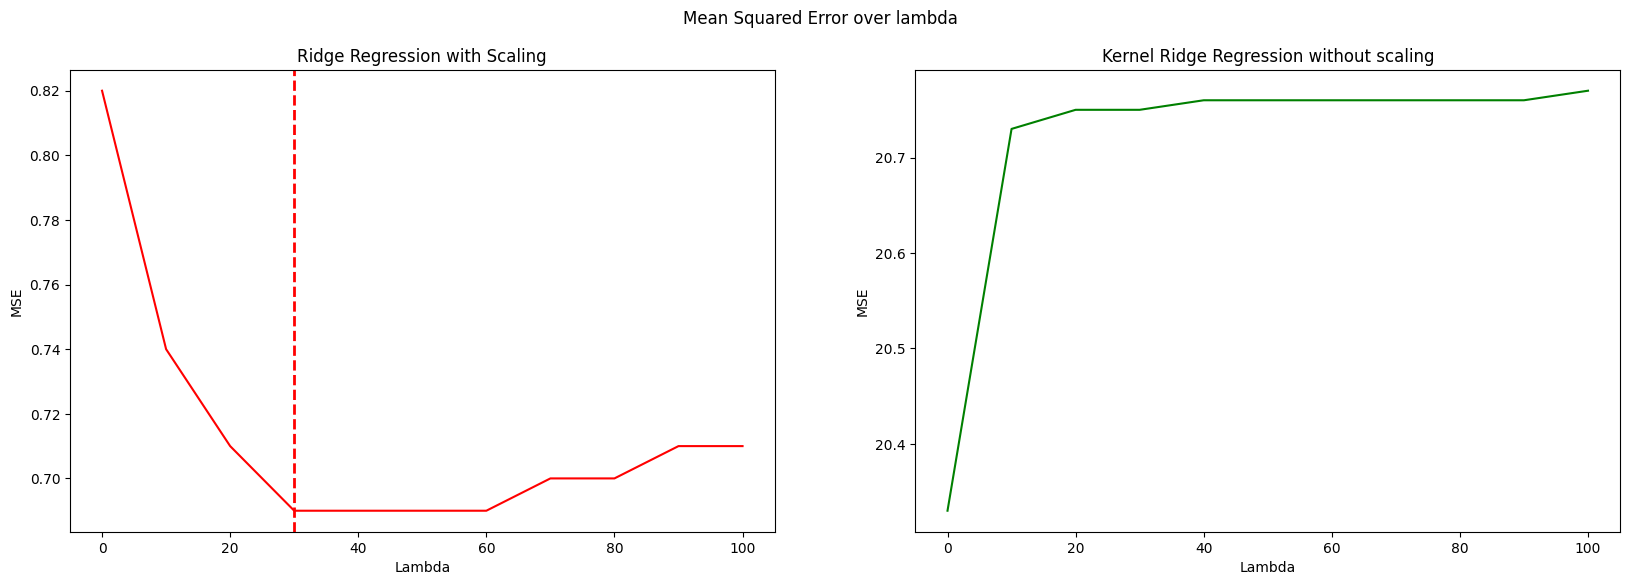

In [228]:
import matplotlib.pyplot as plt

# Printing the mean squared error for different lambda values
print('Lambda\tRidge MSE\tKernel Ridge MSE')

for i, l in enumerate(lambdas):
    print(f'{l}\t{ridge_mse[i]:.4f}\t\t{kernel_mse[i]:.4f}')
    
# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 6)
fig.suptitle('Mean Squared Error over lambda')
ax1.plot(lambdas, ridge_mse, c="red")
ax2.plot(lambdas, kernel_mse, c="green")
ax1.set_title("Ridge Regression with Scaling")
ax2.set_title("Kernel Ridge Regression without scaling")
ax1.set_xlabel("Lambda")
ax2.set_xlabel("Lambda")
ax1.set_ylabel("MSE")
ax2.set_ylabel("MSE")

# Add vertical line at x=40
ax1.axvline(x=30, color='r', linestyle='--', linewidth=2)

plt.show()


In the first model we can see that the regularization added by the Ridge method helps to decrease overfitting the higher lambda gets. Inducing some bias in order to reward in a smaller variance allows us to get a smaller final MSE, and this is why until lambda = 30 the model imporves by becoming simpler and less flexible with smaller values of regression coefficients. From lambda = 30 onwards, we get underfitting because the model becomes to simple and the bias error gets really high compared to the decrease of the variance. Therefore, the reguularization must be done by hypertuning lambda to 30, 60 or something in-between.

For the second method, it can be seen that regularization does not help. We start with a high MSE and once lambda starts to increase its value, the MSE becomes higher. The plot says us that the decrase in flexibility for the model will be bad due to the fact that the lambda value is far beyond the optimal point, which theoretically could be in the negative side of the lambda values. Also, I would like to emphasize that this second model's results seems not to be really trustworthy due to the fact that the regularization seems not to help for any value of lambda, and because once lambda surpasses the 10 value, the MSE gets stagnant in a value close to 20. I just wanted to comment on the fact that this analysis seems weird, compared to the one of the first model. 


(2) Plot the regression coefficients (βˆ for method I and αˆ for method II) versus the effective degrees of freedom (as shown in Figure 3.8 of the book). Note that in order to fully observe the shrinkage effect, you need λ = {0, . . . , 10000} for method I, and λ = {0, . . . , 100} for method II.  

You are required to implement method I and method II using the equations learned from this class. No credit will be given if you use library functions to substitute them


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


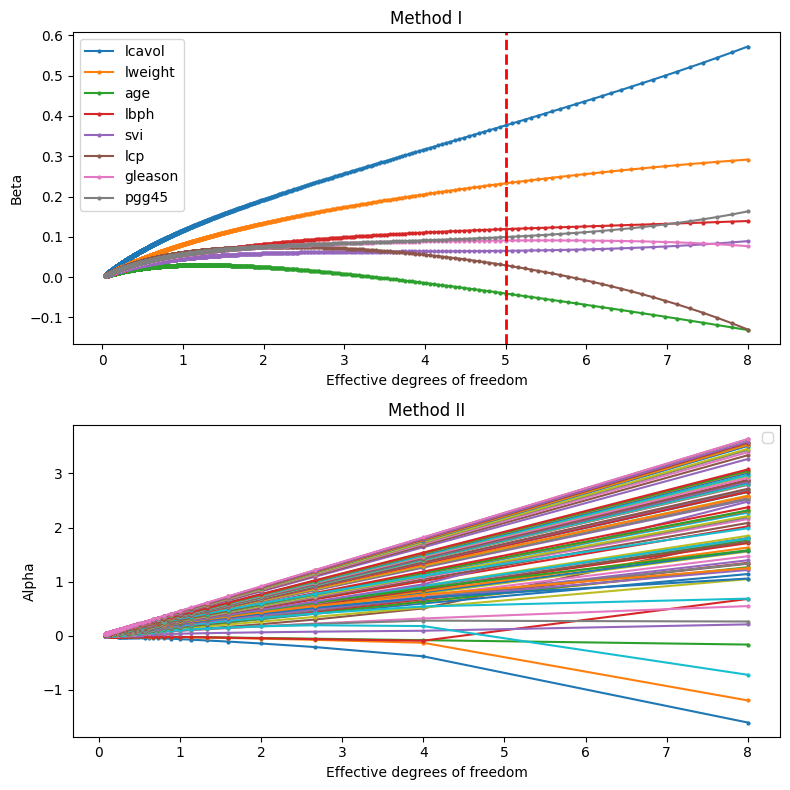

In [229]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some random data
n = X_train_scaled.shape[0]
p = X_train_scaled.shape[1]
X_1 = X_train_scaled
y_1 = y_train_scaled 
X_2 = X_train
y_2 = y_train

# Define the range of lambda values for each method
lambda1 = np.arange(0, 10001)
lambda2 = np.arange(0, 101)

# Define the function to calculate the effective degrees of freedom for each lambda
def eff_df(lambda_, method):
    if method == 1:
        return np.sum(1 / (1 + lambda_ * np.diag(np.linalg.inv(X_1.T @ X_1))))
    elif method == 2:
        return np.sum(1 / (1 + lambda_ * np.ones(p)))

# Calculate the regression coefficients for each lambda value for each method
beta1 = np.zeros((len(lambda1), p))
beta2 = np.zeros((len(lambda2), 87))
for i, lambda_ in enumerate(lambda1):
    beta1[i] = np.linalg.inv(X_1.T @ X_1 + lambda_ * np.identity(p)) @ X_1.T @ y_1
for i, lambda_ in enumerate(lambda2):
    # beta2[i] = np.linalg.inv(X_2.T @ X_2 + lambda_ * np.ones((p, p))) @ X_2.T @ y_2
    beta2[i] = kernel_ridge.fit(X_train, y_train, lambda_)

# Calculate the effective degrees of freedom for each lambda value for each method
df1 = np.zeros(len(lambda1))
df2 = np.zeros(len(lambda2))
for i, lambda_ in enumerate(lambda1):
    df1[i] = eff_df(lambda_, 1)
for i, lambda_ in enumerate(lambda2):
    df2[i] = eff_df(lambda_, 2)

names = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']

# Plot the regression coefficients vs. effective degrees of freedom
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
for i in range(p):
    # ax[0].plot(df1, beta1[:, i], label=f'Beta {i+1}', marker='o', markersize=2)
    ax[0].plot(df1, beta1[:, i], label=names[i], marker='o', markersize=2)

ax[0].axvline(x=5, color='r', linestyle='--', linewidth=2)

ax[0].set_xlabel('Effective degrees of freedom')
ax[0].set_ylabel('Beta')
ax[0].set_title('Method I')
ax[0].legend()

for i in range(87):
    ax[1].plot(df2, beta2[:, i], marker='o', markersize=2)
ax[1].set_xlabel('Effective degrees of freedom')
ax[1].set_ylabel('Alpha')
ax[1].set_title('Method II')
ax[1].legend()
plt.tight_layout()
plt.show()


Method I has one beta coefficient per attribute.  
Method II has one alpha coefficient per row of the K matrix, which defines the alpha coefficient as we have seen in the theory. In this case, it is a 87 dimension vector.